In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import scipy as si
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [5]:
# merge puma codes with sub-bourough data
puma_cd_name = pd.read_csv('../data/PUMA_CD_NAME.csv',index_col = 0)
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_rents = median_rents.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_rents = median_rents.set_index('puma')
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
median_incomes = median_incomes.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_incomes = median_incomes.set_index('puma')
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
education_levels = education_levels.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
education_levels = education_levels.set_index('puma')
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
percents_white = percents_white.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
percents_white = percents_white.set_index('puma')
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')

In [6]:
median_rents.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cd,CD_Name
puma,,,,,,,,,,,,,,,,,,
4109,gross_rent_adj,"Median rent, all ($2016)",Sunnyside/Woodside,1130,1280,1270,1340,1280,1360,1410,1430,1460,1460,1570,1600,1570,QN02,Sunnyside/Woodside
3810,gross_rent_adj,"Median rent, all ($2016)",Greenwich Village/Financial District,1680,2010,2100,2160,2180,990,1530,1280,1360,1520,1300,2680,2530,MN01MN02,Greenwich Village/Financial District
3708,gross_rent_adj,"Median rent, all ($2016)",Highbridge/South Concourse,870,930,950,990,1000,1000,1040,1040,1030,1110,1060,1100,1110,BX04,Highbridge/South Concourse
3903,gross_rent_adj,"Median rent, all ($2016)",North Shore,1010,1150,1130,1210,1200,1130,1240,1160,1120,1100,1130,1180,1220,SI01,North Shore
3710,gross_rent_adj,"Median rent, all ($2016)",Mott Haven/Hunts Point,550,630,730,720,740,780,770,770,780,850,830,860,950,BX01BX02,Mott Haven/Hunts Point


In [7]:
income_diffs = pd.DataFrame(index = median_incomes.index, columns=['Sub-Borough Area'])
income_diffs['Sub-Borough Area'] = median_incomes['Sub-Borough Area']
income_diffs['2005'] = median_incomes['2005'] - nyc_median_incomes['2005'][0]
low_income = income_diffs['2005'] < income_diffs['2005'].quantile(q=0.4)
income_diffs[low_income]['Sub-Borough Area']

puma
3709                   Soundview/Parkchester
3801               Washington Heights/Inwood
4014                            Borough Park
3708              Highbridge/South Concourse
3803                          Central Harlem
4101                                 Astoria
4015                                Flatbush
3705                      Morrisania/Belmont
4008             East New York/Starrett City
4006    North Crown Heights/Prospect Heights
3802    Morningside Heights/Hamilton Heights
4001                 Williamsburg/Greenpoint
3707              University Heights/Fordham
3706             Kingsbridge Heights/Moshulu
3710                  Mott Haven/Hunts Point
3809               Lower East Side/Chinatown
3804                             East Harlem
4007                  Brownsville/Ocean Hill
4011                     South Crown Heights
4018                            Coney Island
4003                      Bedford Stuyvesant
4002                                Bushwick
Name:

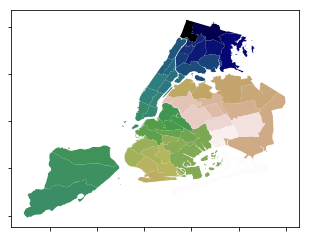

In [8]:
sbas = gpd.read_file('../data/Public Use Microdata Areas (PUMA)/')
sbas['puma'] = sbas['puma'].astype('int64')
ax = sbas.plot(cmap='gist_earth')
ax.set(xticklabels=[],yticklabels=[])
plt.show()

In [9]:
sbas = sbas.merge(puma_cd_name, on='puma')

In [10]:
puma_cd = pd.read_csv('../data/PUMA_CD_NAME.csv')
puma_cd['cd'] = puma_cd['cd'].str.replace(" ", "")
sbas['cd'] = sbas['cd'].str.replace(" ","")

In [11]:
G = nx.Graph()
G.add_nodes_from(sbas.index)
n = len(sbas.index)
for i,row in sbas.iterrows():
    for j in range(i+1,n):
        if row['geometry'].touches(sbas.loc[j]['geometry']):
            dist = row['geometry'].centroid.distance(sbas.loc[j]['geometry'].centroid) 
            G.add_edge(i,j, weight=dist)

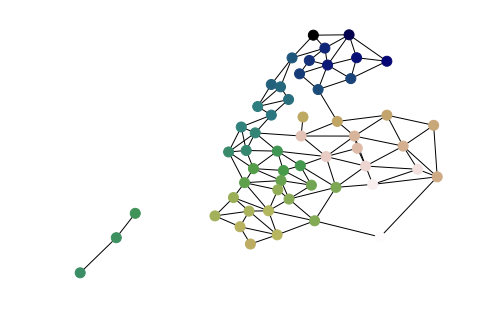

In [12]:
nx.draw(G, pos = sbas['geometry'].centroid.map(lambda p: (p.x,p.y)).to_dict(), node_size=100, node_color=range(n), cmap=plt.cm.gist_earth)
plt.show()

In [13]:
years = ['2000'] + [str(y) for y in range(2005,2017)]
columns = ['cd'] + years
# neighbor_mean = np.zeros(len(sbas.index), len(years))
# moransi = np.zeros(len(sbas.index), len(years))
mean_rents = median_rents.mean()
neighbor_means = pd.DataFrame()
for v in G.nodes():
    puma = sbas.iloc[v]['puma']
    neighbors = G[v].keys()
    neighbor_cds = list(sbas.iloc[neighbors]['cd'])
    rent_rows = median_rents[median_rents['cd'].isin(neighbor_cds)][columns]
    mean_row = rent_rows.mean()
    mean_row['puma'] = puma
    neighbor_means = neighbor_means.append(mean_row, ignore_index=True)

In [14]:
neighbor_means['puma'] = neighbor_means['puma'].astype('int64')
neighbor_means = neighbor_means.merge(puma_cd_name, on = 'puma')
neighbor_means = neighbor_means.set_index('puma')

In [15]:
# wmatrix = pysal.weights.WSP(nx.adj_matrix(G))

In [16]:
subways = pd.read_csv('../data/communitydistrict-residentialunitswithin12mileofasubwaystation.csv')

In [17]:
subways['cd'], subways['CD_Name'] = subways['Community District'].str.split(" - ",1).str
subways['cd'] = subways['cd'].str.replace(" ", "")

In [18]:
# # Merge community district data into PUMAs based on 2010 census
housing_units = pd.read_csv('../data/community_district_housing_units2010.csv')
housing_units['cd'] = housing_units['Community_District'].str.lstrip()
housing_units['cd'] = housing_units['cd'].str.rstrip()
housing_units['Borough'], housing_units['CD_Number'] = housing_units['cd'].str.split(" ",1).str
housing_units['CD_Number']= housing_units['CD_Number'].str.zfill(2)
housing_units['cd'] = housing_units['Borough'] + housing_units['CD_Number']
housing_units = housing_units[['cd', 'Units']]
housing_units['Units'] = housing_units['Units'].str.replace(',','').astype('int64')

In [19]:
merging = [('BX01', 'BX02'), ('BX03', 'BX06'), ('MN01', 'MN02'), ('MN04', 'MN05')]
subways = subways[['cd', '2016']]
merged = []
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    newval = u *subways[subways['cd']==a]['2016'].values[0] + v * subways[subways['cd']==b]['2016'].values[0]
    newval = newval / float(denom)
    merged.append({
        'cd': a + b, 
        '2016': newval})
subways = subways.append(merged, ignore_index = True)

In [20]:
subways = subways.merge(puma_cd_name, on = 'cd', how = 'outer')

In [21]:
subways = subways.dropna(how='any')

In [22]:
population = pd.read_csv('../data/community_district_population2010.csv')
population['cd'] = population['Community_District'].str.lstrip()
population['cd'] = population['cd'].str.rstrip()
population['Borough'], population['CD_Number'] = population['cd'].str.split(" ",1).str
population['CD_Number']= population['CD_Number'].str.zfill(2)
population['cd'] = population['Borough'] + population['CD_Number']
population = population[['cd', 'Population']]

In [23]:
subways = subways.set_index('puma')

In [24]:
new_units = pd.read_csv('../data/communitydistrict-unitsauthorizedbynewresidentialbuildingpermits.csv')
new_units['cd'], new_units['Name'] = new_units['Community District'].str.split(" - ",1).str
new_units['cd'] = new_units['cd'].str.replace(' ','')
years = [str(n) for n in range(2000,2017)]
indices = ['cd', 'Name'] + years
new_units = new_units[indices]
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    row1 = new_units[new_units['cd']==a][years].values
    row2 = new_units[new_units['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    new_units = new_units.append(newrow, ignore_index = True)

In [25]:
new_units = new_units.merge(puma_cd_name, on='cd', how='outer')
new_units = new_units[pd.notnull(new_units['CD_Name'])]
new_units['puma'] = new_units['puma'].astype('int64')
new_units = new_units.set_index('puma')

In [26]:
crime = pd.read_csv('../data/communitydistrict-seriouscrimerateper1000residents.csv')
crime['cd'], crime['CD_Name'] = crime['Community District'].str.split(" - ",1).str
crime['cd'] = crime['cd'].str.replace(' ','')
years = [str(n) for n in range(2006,2017)]
indices = ['cd'] + years
crime = crime[indices]
for i,(a,b) in enumerate(merging):
    u = float(population[population['cd']==a]['Population'].values[0])
    v = float(population[population['cd']==b]['Population'].values[0])
    denom = u + v
    row1 = crime[crime['cd']==a][years].values
    row2 = crime[crime['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    crime = crime.append(newrow, ignore_index = True)

In [27]:
crime = crime.merge(puma_cd_name, on='cd', how='outer')
crime = crime[pd.notnull(crime['CD_Name'])]
crime['puma'] = crime['puma'].astype('int64')
crime = crime.set_index('puma')

In [28]:
years = [str(y) for y in range(2005,2017)]
subways = pd.concat([subways['2016']]*12, axis=1)
subways.columns = years

In [29]:
# horrendous and lazy way to fill in missing values
lineup = crime['2006'].values
crime.insert(0, '2005', lineup)

In [30]:
median_incomes = median_incomes.sort_index()
education_levels = education_levels.sort_index()
percents_white = percents_white.sort_index()
percents_white[years] = percents_white[years].interpolate(method='linear', axis = 0)
subways = subways.sort_index()
new_units[years] = new_units[years].interpolate(method='linear', axis = 0)
new_units = new_units.sort_index()
crime = crime.sort_index()
neighbor_means = neighbor_means.sort_index()
median_rents = median_rents.sort_index()

In [31]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs
# Stack our observations: first axis is PUMA, second is year, third is feature
Xs = np.dstack([median_incomes[years].values, 
                     education_levels[years].values, 
                     percents_white[years].values, 
                     subways[years].values, 
                     new_units[years].values, 
                     crime[years].values, 
                     neighbor_means[years].values, 
                     median_rents[years].ewm(com=2).mean().values])

# Observations
Y = median_rents[years].astype('float32').values
X_test = Xs[:,-1,:]
Y_test = Y[:,-1]
Y = Y[:,:-1]
X = Xs[:, :-1, :]
clf = tree.DecisionTreeRegressor()
predictions = np.zeros(k)
resids = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i] = clf.predict(X_test[i,:].reshape(1, -1))

In [32]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.plot(errs, 'o-')
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
ax.set_title('Decision Tree Prediction Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
plt.ylabel('Error (Dollars/Month)')
plt.show()

NameError: name 'errs' is not defined

In [ ]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Decision Tree Predictions')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [ ]:
n = 12 # number of years
m = 6 # number of features
k = 55 # number of PUMAs

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values]

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

Xs = np.dstack(features)
    
# Normalize Observations
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))
X_test = Xs[:,-2:,:]
Y_test = Y[:,-2:]
Y = Y[:,:-2]
X = Xs[:, :-2, :]
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X[i], Y[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X[i], Y[i])
    mses[i] = mean_squared_error(Y[i], clf.predict(X[i]))
    residslin1[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

In [40]:
n = 12 # number of years
m = 8 # number of features
k = 55 # number of PUMAs

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values, neighbor_means[years].values, median_rents[years].ewm(com=2).mean().values]
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'subways', 'new_units', 'crime', 'spatial_lag','emw']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = Xs[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = Xs[:, :-2, :]

In [41]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_

In [42]:
pcsbyneighborhood = pd.DataFrame(pcas[1], columns = feature_labels).transpose()
pcsbyneighborhood

,0,1,2,3,4,5,6,7
median_incomes,-0.999830,-0.013968,-1.205054e-02,7.552370e-04,7.209276e-05,-1.184920e-06,2.870133e-06,-3.164740e-20
education_level,0.000002,-0.000013,-2.955480e-04,2.562578e-04,-4.030553e-02,-9.981833e-01,-4.478267e-02,2.472465e-14
percent_white,-0.000001,0.000005,-8.655818e-05,-1.119293e-04,1.270203e-02,4.430360e-02,-9.989374e-01,5.058392e-14
subways,0.000000,-0.000000,1.387779e-17,-1.110223e-16,4.857226e-16,2.223699e-14,5.170170e-14,1.000000e+00
new_units,-0.011965,0.987605,-1.490719e-01,4.764004e-02,-1.121503e-03,8.831468e-05,1.907526e-06,8.297453e-19
crime,0.000120,0.000677,-5.166457e-03,-6.580427e-03,9.990714e-01,-4.083032e-02,1.089407e-02,-1.435485e-16
spatial_lag,0.008872,-0.121892,-5.427053e-01,8.309795e-01,2.759167e-03,2.642530e-04,1.349439e-07,-1.464778e-18
emw,0.010910,-0.097894,-8.264844e-01,-5.542197e-01,-7.842792e-03,4.181105e-04,5.205868e-05,1.193874e-18


In [43]:
pcs1 = pd.DataFrame(pcas[:,0], columns = feature_labels)

In [44]:
pcs1

,median_incomes,education_level,percent_white,subways,new_units,crime,spatial_lag,emw
0,0.999952,-1.344140e-06,1.722254e-06,-4.135903e-25,0.003490,0.000103,-0.008773,-0.002586
1,-0.999830,2.090653e-06,-1.111326e-06,0.000000e+00,-0.011965,0.000120,0.008872,0.010910
2,0.999985,-1.676456e-06,1.144067e-05,3.210619e-39,0.002138,0.000035,-0.004738,-0.001606
3,0.995452,1.096486e-06,7.094259e-06,-4.135903e-25,0.094427,0.000144,-0.008368,-0.009403
4,0.999699,2.356198e-06,8.585093e-07,3.391370e-38,0.024137,-0.000356,-0.001278,0.004138
5,-0.999866,-5.786358e-06,-2.706374e-06,0.000000e+00,0.000580,-0.000141,0.012976,0.009938
6,-0.999969,6.048093e-07,-1.477009e-06,5.169879e-26,-0.006551,0.000046,0.002898,0.003174
7,0.999507,1.597984e-06,8.976065e-07,-8.271806e-25,-0.031231,-0.000076,0.002804,-0.001621
8,-0.999931,-4.340190e-07,-9.608845e-07,-6.462349e-27,-0.006345,-0.000057,0.007166,0.006834
9,-0.999350,-4.128050e-06,-1.125381e-06,-4.135903e-25,0.032627,-0.000156,-0.009423,-0.012068


In [45]:
# Linear Regression
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X_train[i], Y_train[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X_train[i], Y_train[i])
    mses[i] = mean_squared_error(Y_train[i], clf.predict(X_train[i]))
    residslin2[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

In [46]:
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residsexp = np.zeros(k)
for i in range(k-1):
    fit2 = SimpleExpSmoothing(Y_train[i]).fit(smoothing_level=0.6,optimized=False)
    predictions[i,:] = fit2.forecast(1)
    mses[i] = mean_squared_error(Y_test[i], predictions[i])
    residsexp[i] = Y_test[i,1] - predictions[i,1]

In [49]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(10,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(10,1), axis=1).T)
    Cs=np.dstack([Cs,m])

ValueError: cannot reshape array of size 12 into shape (10,1)

In [48]:
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

NameError: name 'Cs' is not defined

In [36]:
fig, ax = plt.subplots()
ax.stem(range(k),np.abs(residslin1), markerfmt='b_', linefmt='b', basefmt=' ')
ax.stem(range(k),np.abs(residslin2), markerfmt='r_', linefmt='r', basefmt=' ')
ax.stem(range(k),np.abs(residsexp), markerfmt='g_', linefmt='g', basefmt= ' ')
plt.title('Residuals for Different 2-Year Predictions')
plt.xlabel('Neighborhood')
plt.ylabel('Residual Magnitude (Dollars)')
plt.show()

NameError: name 'residslin1' is not defined

In [ ]:
sns.distplot(residslin1, kde=False, color = 'b')
plt.show()

In [ ]:
sns.distplot(residslin2, kde=False, color = 'r')
plt.show()

In [ ]:
sns.distplot(residsexp, kde=False, color = 'g')
plt.show()

In [ ]:
residstree = np.zeros(k)
for i in range(k):
    regr = tree.DecisionTreeRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X[i],Y[i])
    residstree[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))

In [ ]:
sns.distplot(residstree, kde=False, color = 'c')
plt.show()

In [3]:
residsfrst = np.zeros(k)
for i in range(k):
    regr = RandomForestRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X_test[i],Y_test[i])
    residsfrst[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))

NameError: name 'np' is not defined

In [ ]:
sns.distplot(residsfrst, kde=False, color = 'y')
plt.show()

In [95]:
train_features = ['median_incomes', 'education_level', 'percent_white', 'new_units',
       'crime', 'spatial_lag', 'emw']
resids = np.zeros((55,1))

for i in range(0,55):
    focus = pd.DataFrame(X[i], columns = feature_labels)
    focus = focus.drop('subways', axis = 1)
    focus_obs = pd.DataFrame(Y[i], columns = ['median_rent'])
    focus = pd.concat([focus, focus_obs.shift(-1)], axis=1)
    focus.dropna(how='any')
    test = focus[train_features].iloc[10]
    test_X = test.values
    test_X = test_X.reshape(1,1,7)
    train = focus.iloc[:10]
    train_X = train[train_features].values
    train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
    train_Y = train['median_rent'].values
    train_Y = train_Y.reshape(10,1)
    test_Y = Y[i,10]
    test_Y = test_Y.reshape(1,1)
    
    # build model
    n_batch = 10
    n_epoch = 500
    n_neurons = 8

    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    for k in range(n_epoch):
        model.fit(train_X, train_Y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()

    # re-define the batch size
    n_batch = 1
    # re-define model
    new_model = Sequential()
    new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    new_model.add(Dense(1))
    # copy weights
    old_weights = model.get_weights()
    new_model.set_weights(old_weights)

    # compile model
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    # online forecast
    yhat = new_model.predict(test_X, batch_size=n_batch)
    resids[i,:] = yhat - test_Y

Epoch 1/1
10/10 [==============================] - 1s 77ms/step - loss: 0.0387
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 0.0383
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0378
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 0.0373
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 0.0369
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0364
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0360
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 0.0356
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0352
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 0.0348
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0343
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0340
Epoch 1/1
10/10 [========================

Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 352us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0102
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0101
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 277us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 694us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 911us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 609us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 606us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 742us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 725us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 0.0050
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 670us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 531us/step - loss: 0.0029
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 692us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 540us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 657us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 875us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 241us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0017
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 816us/step - loss: 0.0665
Epoch 1/1
10/10 [==============================] - 0s 754us/step - loss: 0.0658
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0650
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0642
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0635
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0627
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 0.0620
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0612
Epoch 1/1
10/10 [==============================] - 0s 908us/step - loss: 0.0605
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0598
Epoch 1/1
10/10 [==============================] - 0s 643us/step - loss: 0.0591
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0584
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 888us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 885us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 594us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0135
Epoch 1/1
10/10 [==============================] - 0s 591us/step - loss: 0.0132
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0125
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 0.0026
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 9.5638e-04
Epoch 1/1
10/10 [==============================] - 0s 516us/step - loss: 9.4816e-04
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 9.4007e-04
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 9.3210e-04
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 9.2424e-04
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 9.1650e-04
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 9.0887e-04
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 9.0135e-04
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 8.9393e-04
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 8.8663e-04
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 8.7942e-04
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 8.723

Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 5.0049e-04
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 4.9789e-04
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 4.9532e-04
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 4.9276e-04
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 4.9023e-04
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 4.8772e-04
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 4.8522e-04
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 4.8275e-04
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 4.8030e-04
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 4.7786e-04
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 4.7545e-04
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 4.7

Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 0.0475
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 0.0473
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0472
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0470
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0468
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 0.0466
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0465
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0463
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0462
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 0.0460
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0458
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0457
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 0.0361
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0360
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0359
Epoch 1/1
10/10 [==============================] - 0s 616us/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 0.0357
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 0.0356
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 0.0356
Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 0.0355
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 0.0354
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0353
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0352
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0250
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 0.0249
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 0.0248
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 0.0246
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0245
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0244
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 0.0242
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0241
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0240
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 0.0238
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0237
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0236
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 540us/step - loss: 0.0134
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0134
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0133
Epoch 1/1
10/10 [==============================] - 0s 357us/step - loss: 0.0132
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0131
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 0.0131
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 248us/step - loss: 0.0127
Epoch 1/1
10/10 [==============================] - 0s 296us/step - loss: 0.0127
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 0.0126
Epoch 1/1
10/10 [=======================

10/10 [==============================] - 0s 360us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 282us/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] -

Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0297
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0294
Epoch 1/1
10/10 [==============================] - 0s 556us/step - loss: 0.0291
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0288
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0284
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0281
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0278
Epoch 1/1
10/10 [==============================] - 0s 265us/step - loss: 0.0275
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0272
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0269
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 0.0266
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0263
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0060
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0056
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 601us/step - loss: 0.0015
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0015
Epoch 1/1
10/10 [==============================] - 0s 291us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 285us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 421us/step - loss: 0.0014
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0014
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 8.7131e-04
Epoch 1/1
10/10 [==============================] - 0s 568us/step - loss: 8.6783e-04
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 8.6437e-04
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 8.6092e-04
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 8.5749e-04
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 8.5407e-04
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 8.5067e-04
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 8.4729e-04
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 8.4392e-04
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 8.4056e-04
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 8.3721e-04
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 8.3

Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 5.8266e-04
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 5.8013e-04
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 5.7761e-04
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 5.7509e-04
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 5.7258e-04
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 5.7008e-04
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 5.6758e-04
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 5.6510e-04
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 5.6262e-04
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 5.6015e-04
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 5.5768e-04
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 5.5

Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0214
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0212
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0209
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0206
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0204
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0201
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0199
Epoch 1/1
10/10 [==============================] - 0s 512us/step - loss: 0.0196
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 0.0194
Epoch 1/1
10/10 [==============================] - 0s 592us/step - loss: 0.0191
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0189
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0186
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 0.0060
Epoch 1/1
10/10 [==============================] - 0s 283us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 288us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 0.0055
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 481us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 590us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0021
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0011
Epoch 1/1
10/10 [==============================] - 0s 604us/step - loss: 0.0011
Epoch 1/1
10/10 [==============================] - 0s 708us/step - loss: 0.0011
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0011
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 0.0011
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 7.9281e-04
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 7.8971e-04
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 7.8662e-04
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 7.8354e-04
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 7.8046e-04
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 7.7739e-04
Epoch 1/1
10/10 [==============================] - 0s 527us/step - loss: 7.7433e-04
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 7.7128e-04
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 7.6824e-04
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 7.6520e-04
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 7.6217e-04
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 7.5

Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0326
Epoch 1/1
10/10 [==============================] - 0s 702us/step - loss: 0.0322
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0317
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 0.0313
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 0.0309
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0305
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0301
Epoch 1/1
10/10 [==============================] - 0s 280us/step - loss: 0.0296
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0292
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0288
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0284
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 0.0281
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0089
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0088
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0083
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 0.0048
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 292us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0034
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 267us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0025
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0589
Epoch 1/1
10/10 [==============================] - 0s 305us/step - loss: 0.0586
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 0.0582
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0579
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0576
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0573
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0570
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 0.0567
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0564
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0561
Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 0.0558
Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0554
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0285
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 0.0282
Epoch 1/1
10/10 [==============================] - 0s 314us/step - loss: 0.0280
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 0.0277
Epoch 1/1
10/10 [==============================] - 0s 286us/step - loss: 0.0275
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0272
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0270
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0267
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0265
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0262
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0260
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0258
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 481us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 352us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0135
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 636us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 754us/step - loss: 0.0121
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0113
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 592us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0101
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0099
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0097
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 556us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 759us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 730us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0034
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 861us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 596us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0029
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 824us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0025
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 1s 132ms/step - loss: 0.0752
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 0.0745
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0737
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 263us/step - loss: 0.0290
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0287
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0284
Epoch 1/1
10/10 [==============================] - 0s 390us/step - loss: 0.0282
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 0.0279
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0276
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0274
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0271
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0269
Epoch 1/1
10/10 [==============================] - 0s 298us/step - loss: 0.0266
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0264
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0261
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 655us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0167
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0167
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0167
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0166
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0166
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 0.0164
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 266us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 323us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 652us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 0.0135
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 0.0135
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0135
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 603us/step - loss: 0.0112
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 0.0314
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 0.0311
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0308
Epoch 1/1
10/10 [==============================] - 0s 654us/step - loss: 0.0306
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0303
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0300
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 0.0297
Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 0.0294
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0291
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 0.0289
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 0.0286
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0283
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 698us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 274us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 294us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0102
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0101
Epoch 1/1
10/10 [=======================

10/10 [==============================] - 0s 417us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 523us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] -

Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 597us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0027
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 0.0019
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0019
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 560us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0018
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 1/1
10/10 [==============================] - 0s 675us/step - loss: 0.0580
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0576
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 0.0571
Epoch 1/1
10/10 [==============================] - 0s 618us/step - loss: 0.0567
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 0.0563
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0558
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0554
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0550
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0545
Epoch 1/1
10/10 [==============================] - 0s 353us/step - loss: 0.0541
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0537
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 815us/step - loss: 0.0218
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0216
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0213
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0211
Epoch 1/1
10/10 [==============================] - 0s 556us/step - loss: 0.0208
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0206
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0203
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0201
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 0.0199
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0194
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0192
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 635us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0069
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 557us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 329us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 842us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0036
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 540us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 773us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 791us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 778us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 663us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0021
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0481
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 0.0477
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0474
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 0.0470
Epoch 1/1
10/10 [==============================] - 0s 290us/step - loss: 0.0466
Epoch 1/1
10/10 [==============================] - 0s 316us/step - loss: 0.0462
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0459
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0455
Epoch 1/1
10/10 [==============================] - 0s 546us/step - loss: 0.0451
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0448
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0444
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0440
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 0.0191
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0189
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0188
Epoch 1/1
10/10 [==============================] - 0s 318us/step - loss: 0.0186
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0185
Epoch 1/1
10/10 [==============================] - 0s 538us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0182
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0180
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0179
Epoch 1/1
10/10 [==============================] - 0s 577us/step - loss: 0.0177
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0176
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0175
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 693us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0106
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 636us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0073
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 317us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 658us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 696us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 846us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0051
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0411
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0406
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0400
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0395
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0390
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0386
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0381
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 0.0376
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0371
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0367
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0358
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0180
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0179
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0178
Epoch 1/1
10/10 [==============================] - 0s 647us/step - loss: 0.0177
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0176
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0175
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 0.0174
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 0.0173
Epoch 1/1
10/10 [==============================] - 0s 308us/step - loss: 0.0172
Epoch 1/1
10/10 [==============================] - 0s 357us/step - loss: 0.0171
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0170
Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0169
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 327us/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 631us/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 771us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0092
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 0.0091
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 0.0091
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 0.0090
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 986us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 297us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0055
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 284us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 583us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0041
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0360
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0356
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0353
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 0.0349
Epoch 1/1
10/10 [==============================] - 0s 271us/step - loss: 0.0346
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0343
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 0.0339
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 0.0336
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0333
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0330
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0327
Epoch 1/1
10/10 [==============================] - 0s 688us/step - loss: 0.0324
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0133
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 0.0132
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 0.0126
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 0.0125
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0124
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0123
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0120
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0119
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0047
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 752us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 799us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 714us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 718us/step - loss: 0.0044
Epoch 1/1
10/10 [==============================] - 0s 541us/step - loss: 0.0044
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0042
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 973us/step - loss: 0.0019
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0019
Epoch 1/1
10/10 [==============================] - 0s 714us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 683us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 770us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 772us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 678us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 717us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 505us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0017
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 928us/step - loss: 8.8487e-04
Epoch 1/1
10/10 [==============================] - 0s 693us/step - loss: 8.7910e-04
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 8.7338e-04
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 8.6771e-04
Epoch 1/1
10/10 [==============================] - 0s 594us/step - loss: 8.6209e-04
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 8.5652e-04
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 8.5100e-04
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 8.4552e-04
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 8.4009e-04
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 8.3471e-04
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 8.2937e-04
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 8.2407e

Epoch 1/1
10/10 [==============================] - 0s 690us/step - loss: 0.0779
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0778
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0776
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0775
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0774
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0772
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0771
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0769
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0768
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0766
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0765
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0764
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0653
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 0.0652
Epoch 1/1
10/10 [==============================] - 0s 559us/step - loss: 0.0651
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 0.0650
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 0.0649
Epoch 1/1
10/10 [==============================] - 0s 336us/step - loss: 0.0648
Epoch 1/1
10/10 [==============================] - 0s 672us/step - loss: 0.0647
Epoch 1/1
10/10 [==============================] - 0s 751us/step - loss: 0.0645
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0644
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0643
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0642
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 0.0641
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0529
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0528
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0526
Epoch 1/1
10/10 [==============================] - 0s 582us/step - loss: 0.0525
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0524
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0522
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0521
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0520
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0518
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0517
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0516
Epoch 1/1
10/10 [==============================] - 0s 631us/step - loss: 0.0514
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0372
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0370
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0368
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0367
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0365
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0363
Epoch 1/1
10/10 [==============================] - 0s 322us/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 299us/step - loss: 0.0360
Epoch 1/1
10/10 [==============================] - 0s 320us/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0356
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0355
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 0.0353
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 0.0199
Epoch 1/1
10/10 [==============================] - 0s 300us/step - loss: 0.0198
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0196
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0195
Epoch 1/1
10/10 [==============================] - 0s 712us/step - loss: 0.0193
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0192
Epoch 1/1
10/10 [==============================] - 0s 606us/step - loss: 0.0190
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0189
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 0.0187
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 0.0186
Epoch 1/1
10/10 [==============================] - 2s 210ms/step - loss: 0.0273
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 0.0271
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 592us/step - loss: 0.0187
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0186
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0185
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0184
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 516us/step - loss: 0.0182
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0181
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0180
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0180
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0179
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0178
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 639us/step - loss: 0.0102
Epoch 1/1
10/10 [==============================] - 0s 546us/step - loss: 0.0101
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0100
Epoch 1/1
10/10 [==============================] - 0s 568us/step - loss: 0.0099
Epoch 1/1
10/10 [==============================] - 0s 560us/step - loss: 0.0098
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0098
Epoch 1/1
10/10 [==============================] - 0s 591us/step - loss: 0.0097
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0094
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 582us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 347us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0026
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 5.8225e-04
Epoch 1/1
10/10 [==============================] - 0s 770us/step - loss: 5.7413e-04
Epoch 1/1
10/10 [==============================] - 0s 784us/step - loss: 5.6619e-04
Epoch 1/1
10/10 [==============================] - 0s 603us/step - loss: 5.5841e-04
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 5.5079e-04
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 5.4333e-04
Epoch 1/1
10/10 [==============================] - 0s 620us/step - loss: 5.3603e-04
Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 5.2887e-04
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 5.2186e-04
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 5.1500e-04
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 5.0827e-04
Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 5.0

Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 1.9494e-04
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 1.9291e-04
Epoch 1/1
10/10 [==============================] - 3s 334ms/step - loss: 0.0759
Epoch 1/1
10/10 [==============================] - 0s 847us/step - loss: 0.0754
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0750
Epoch 1/1
10/10 [==============================] - 0s 878us/step - loss: 0.0746
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0742
Epoch 1/1
10/10 [==============================] - 0s 775us/step - loss: 0.0738
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0734
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0731
Epoch 1/1
10/10 [==============================] - 0s 567us/step - loss: 0.0727
Epoch 1/1
10/10 [==============================] - 0s 537us/step - loss: 0.0723
Epoch 1/1
10/10 [===================

Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 0.0484
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 0.0482
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0479
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0477
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0474
Epoch 1/1
10/10 [==============================] - 0s 892us/step - loss: 0.0472
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0470
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0467
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0465
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0462
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0460
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0457
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0264
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 0.0263
Epoch 1/1
10/10 [==============================] - 0s 553us/step - loss: 0.0261
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 0.0260
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0258
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0257
Epoch 1/1
10/10 [==============================] - 0s 531us/step - loss: 0.0255
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0254
Epoch 1/1
10/10 [==============================] - 0s 597us/step - loss: 0.0252
Epoch 1/1
10/10 [==============================] - 0s 574us/step - loss: 0.0251
Epoch 1/1
10/10 [==============================] - 0s 352us/step - loss: 0.0249
Epoch 1/1
10/10 [==============================] - 0s 419us/step - loss: 0.0248
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 571us/step - loss: 0.0164
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0164
Epoch 1/1
10/10 [==============================] - 0s 737us/step - loss: 0.0163
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 0.0161
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 0.0161
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0160
Epoch 1/1
10/10 [==============================] - 0s 546us/step - loss: 0.0159
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0159
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 352us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0104
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 562us/step - loss: 0.0951
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0947
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0942
Epoch 1/1
10/10 [==============================] - 0s 333us/step - loss: 0.0938
Epoch 1/1
10/10 [==============================] - 0s 310us/step - loss: 0.0934
Epoch 1/1
10/10 [==============================] - 0s 289us/step - loss: 0.0929
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0925
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0921
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0917
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0913
Epoch 1/1
10/10 [==============================] - 0s 390us/step - loss: 0.0909
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0905
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 610us/step - loss: 0.0589
Epoch 1/1
10/10 [==============================] - 0s 564us/step - loss: 0.0585
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0582
Epoch 1/1
10/10 [==============================] - 0s 902us/step - loss: 0.0578
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0575
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0571
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0568
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 0.0564
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 0.0561
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0557
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0554
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0551
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0239
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0236
Epoch 1/1
10/10 [==============================] - 0s 343us/step - loss: 0.0234
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0231
Epoch 1/1
10/10 [==============================] - 0s 295us/step - loss: 0.0228
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0225
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0223
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 0.0220
Epoch 1/1
10/10 [==============================] - 0s 590us/step - loss: 0.0217
Epoch 1/1
10/10 [==============================] - 0s 302us/step - loss: 0.0215
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0212
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0210
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 907us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 686us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 319us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 625us/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0066
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0034
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0641
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0637
Epoch 1/1
10/10 [==============================] - 0s 934us/step - loss: 0.0634
Epoch 1/1
10/10 [==============================] - 0s 755us/step - loss: 0.0630
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0626
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0622
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0618
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0614
Epoch 1/1
10/10 [==============================] - 0s 558us/step - loss: 0.0611
Epoch 1/1
10/10 [==============================] - 0s 814us/step - loss: 0.0607
Epoch 1/1
10/10 [==============================] - 0s 730us/step - loss: 0.0603
Epoch 1/1
10/10 [==============================] - 0s 531us/step - loss: 0.0599
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0319
Epoch 1/1
10/10 [==============================] - 0s 307us/step - loss: 0.0316
Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0314
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0312
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0309
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0307
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0304
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0302
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 0.0300
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0297
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0295
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 0.0293
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 303us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0153
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 278us/step - loss: 0.0151
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0151
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 558us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 621us/step - loss: 0.0146
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 869us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0102
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0102
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 766us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 605us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0073
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 677us/step - loss: 0.0752
Epoch 1/1
10/10 [==============================] - 0s 740us/step - loss: 0.0747
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0743
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0739
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0735
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0731
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0727
Epoch 1/1
10/10 [==============================] - 0s 824us/step - loss: 0.0722
Epoch 1/1
10/10 [==============================] - 0s 593us/step - loss: 0.0718
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0714
Epoch 1/1
10/10 [==============================] - 0s 337us/step - loss: 0.0710
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0706
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0373
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0370
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0367
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0364
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0361
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0355
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0352
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0349
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0346
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 0.0343
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0340
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 585us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 588us/step - loss: 0.0138
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 643us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0073
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0047
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0047
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0046
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 682us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 682us/step - loss: 0.0044
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0772
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0767
Epoch 1/1
10/10 [==============================] - 0s 504us/step - loss: 0.0763
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0758
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0754
Epoch 1/1
10/10 [==============================] - 0s 685us/step - loss: 0.0749
Epoch 1/1
10/10 [==============================] - 0s 610us/step - loss: 0.0745
Epoch 1/1
10/10 [==============================] - 0s 638us/step - loss: 0.0741
Epoch 1/1
10/10 [==============================] - 0s 809us/step - loss: 0.0736
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0732
Epoch 1/1
10/10 [==============================] - 0s 670us/step - loss: 0.0728
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0724
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 742us/step - loss: 0.0419
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0416
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0413
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0411
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0408
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 0.0406
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0403
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0401
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0398
Epoch 1/1
10/10 [==============================] - 0s 512us/step - loss: 0.0395
Epoch 1/1
10/10 [==============================] - 0s 543us/step - loss: 0.0393
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0391
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0219
Epoch 1/1
10/10 [==============================] - 0s 624us/step - loss: 0.0217
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0216
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0215
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0214
Epoch 1/1
10/10 [==============================] - 0s 660us/step - loss: 0.0212
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 1/1
10/10 [==============================] - 0s 932us/step - loss: 0.0210
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0209
Epoch 1/1
10/10 [==============================] - 0s 725us/step - loss: 0.0207
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0206
Epoch 1/1
10/10 [==============================] - 0s 819us/step - loss: 0.0205
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0125
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 0.0124
Epoch 1/1
10/10 [==============================] - 0s 370us/step - loss: 0.0123
Epoch 1/1
10/10 [==============================] - 0s 777us/step - loss: 0.0123
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0120
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0119
Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 0.0119
Epoch 1/1
10/10 [==============================] - 0s 635us/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0117
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 529us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 934us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 573us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0060
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0571
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0569
Epoch 1/1
10/10 [==============================] - 0s 570us/step - loss: 0.0567
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0564
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0562
Epoch 1/1
10/10 [==============================] - 0s 555us/step - loss: 0.0560
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0558
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0555
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0553
Epoch 1/1
10/10 [==============================] - 0s 660us/step - loss: 0.0551
Epoch 1/1
10/10 [==============================] - 0s 697us/step - loss: 0.0549
Epoch 1/1
10/10 [==============================] - 0s 687us/step - loss: 0.0546
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0340
Epoch 1/1
10/10 [==============================] - 0s 579us/step - loss: 0.0337
Epoch 1/1
10/10 [==============================] - 0s 648us/step - loss: 0.0335
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0333
Epoch 1/1
10/10 [==============================] - 0s 328us/step - loss: 0.0330
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0328
Epoch 1/1
10/10 [==============================] - 0s 797us/step - loss: 0.0326
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 0.0324
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0321
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0319
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0317
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0315
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0133
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0132
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0127
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0125
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0124
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 609us/step - loss: 0.0119
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 805us/step - loss: 0.0117
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 573us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 301us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 565us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 958us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 516us/step - loss: 0.0024
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 4.8995e-04
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 4.8187e-04
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 4.7393e-04
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 4.6615e-04
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 4.5851e-04
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 4.5102e-04
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 4.4367e-04
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 4.3646e-04
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 4.2938e-04
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 4.2243e-04
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 4.1561e-04
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 4.0

Epoch 1/1
10/10 [==============================] - 0s 798us/step - loss: 0.0522
Epoch 1/1
10/10 [==============================] - 0s 710us/step - loss: 0.0519
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0516
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0513
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 0.0510
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0507
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0505
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0502
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0499
Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0496
Epoch 1/1
10/10 [==============================] - 0s 545us/step - loss: 0.0494
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0491
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0284
Epoch 1/1
10/10 [==============================] - 0s 527us/step - loss: 0.0282
Epoch 1/1
10/10 [==============================] - 0s 562us/step - loss: 0.0280
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0278
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0277
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0275
Epoch 1/1
10/10 [==============================] - 0s 313us/step - loss: 0.0273
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0272
Epoch 1/1
10/10 [==============================] - 0s 620us/step - loss: 0.0270
Epoch 1/1
10/10 [==============================] - 0s 685us/step - loss: 0.0269
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0267
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 0.0265
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 390us/step - loss: 0.0164
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0163
Epoch 1/1
10/10 [==============================] - 0s 321us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0161
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0160
Epoch 1/1
10/10 [==============================] - 0s 721us/step - loss: 0.0160
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0159
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0158
Epoch 1/1
10/10 [==============================] - 0s 518us/step - loss: 0.0157
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0098
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0097
Epoch 1/1
10/10 [==============================] - 0s 324us/step - loss: 0.0097
Epoch 1/1
10/10 [==============================] - 0s 419us/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 609us/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 714us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 656us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 1/1
10/10 [=============================

Epoch 1/1
10/10 [==============================] - 0s 784us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 3s 274ms/step - loss: 0.0617
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0613
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0609
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0605
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0601
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0597
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 0.0594
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0590
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0587
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 651us/step - loss: 0.0334
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 0.0332
Epoch 1/1
10/10 [==============================] - 0s 306us/step - loss: 0.0329
Epoch 1/1
10/10 [==============================] - 0s 419us/step - loss: 0.0327
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0325
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0322
Epoch 1/1
10/10 [==============================] - 0s 616us/step - loss: 0.0320
Epoch 1/1
10/10 [==============================] - 0s 801us/step - loss: 0.0317
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0315
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0313
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 0.0310
Epoch 1/1
10/10 [==============================] - 0s 782us/step - loss: 0.0308
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 693us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 304us/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 749us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 421us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0136
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 575us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 652us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 904us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 869us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 788us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0060
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 928us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 706us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 340us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 0.0042
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0368
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0363
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0353
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0348
Epoch 1/1
10/10 [==============================] - 0s 365us/step - loss: 0.0343
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0338
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0334
Epoch 1/1
10/10 [==============================] - 0s 764us/step - loss: 0.0329
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0324
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0320
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0315
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 351us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 591us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0049
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 741us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 666us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 715us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0022
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 714us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 309us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0017
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 671us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 658us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 518us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 574us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 533us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0016
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0412
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0408
Epoch 1/1
10/10 [==============================] - 0s 710us/step - loss: 0.0405
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0402
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0398
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0395
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0392
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0388
Epoch 1/1
10/10 [==============================] - 0s 359us/step - loss: 0.0385
Epoch 1/1
10/10 [==============================] - 0s 614us/step - loss: 0.0382
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0378
Epoch 1/1
10/10 [==============================] - 0s 780us/step - loss: 0.0375
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 968us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0134
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0133
Epoch 1/1
10/10 [==============================] - 0s 838us/step - loss: 0.0132
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0130
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 550us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 697us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 537us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 557us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 413us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 325us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 560us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0063
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 557us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 577us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0048
Epoch 1/1
10/10 [==============================] - 0s 611us/step - loss: 0.0048
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 595us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 589us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 330us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 599us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 688us/step - loss: 0.0041
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0338
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0335
Epoch 1/1
10/10 [==============================] - 0s 311us/step - loss: 0.0331
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0328
Epoch 1/1
10/10 [==============================] - 0s 624us/step - loss: 0.0324
Epoch 1/1
10/10 [==============================] - 0s 744us/step - loss: 0.0321
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 0.0318
Epoch 1/1
10/10 [==============================] - 0s 419us/step - loss: 0.0314
Epoch 1/1
10/10 [==============================] - 0s 315us/step - loss: 0.0311
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0308
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0304
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0301
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 843us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 857us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 835us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 649us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 390us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 660us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 927us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 0.0104
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 658us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 682us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 644us/step - loss: 0.0064
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 841us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 863us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 630us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 533us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 955us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 599us/step - loss: 0.0040
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 913us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 643us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 682us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 869us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 759us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 712us/step - loss: 0.0026
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0785
Epoch 1/1
10/10 [==============================] - 0s 636us/step - loss: 0.0783
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0781
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0779
Epoch 1/1
10/10 [==============================] - 0s 554us/step - loss: 0.0777
Epoch 1/1
10/10 [==============================] - 0s 919us/step - loss: 0.0775
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0773
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0771
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0769
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0767
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0765
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0763
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 596us/step - loss: 0.0602
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0600
Epoch 1/1
10/10 [==============================] - 0s 312us/step - loss: 0.0599
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0597
Epoch 1/1
10/10 [==============================] - 0s 332us/step - loss: 0.0595
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0593
Epoch 1/1
10/10 [==============================] - 0s 339us/step - loss: 0.0591
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0590
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0588
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0584
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0582
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 827us/step - loss: 0.0409
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0407
Epoch 1/1
10/10 [==============================] - 0s 666us/step - loss: 0.0405
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0403
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0401
Epoch 1/1
10/10 [==============================] - 0s 913us/step - loss: 0.0399
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0397
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0395
Epoch 1/1
10/10 [==============================] - 0s 778us/step - loss: 0.0393
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0391
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0389
Epoch 1/1
10/10 [==============================] - 0s 880us/step - loss: 0.0387
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 630us/step - loss: 0.0222
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0220
Epoch 1/1
10/10 [==============================] - 0s 593us/step - loss: 0.0218
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0217
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0215
Epoch 1/1
10/10 [==============================] - 0s 529us/step - loss: 0.0214
Epoch 1/1
10/10 [==============================] - 0s 683us/step - loss: 0.0212
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0211
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0209
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0208
Epoch 1/1
10/10 [==============================] - 0s 789us/step - loss: 0.0206
Epoch 1/1
10/10 [==============================] - 0s 848us/step - loss: 0.0205
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 635us/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 1/1
10/10 [==============================] - 0s 727us/step - loss: 0.0091
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0091
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0089
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0088
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0085
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0167
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0166
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0164
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0163
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0161
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0160
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0160
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0107
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0106
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0105
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0104
Epoch 1/1
10/10 [==============================] - 0s 390us/step - loss: 0.0104
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 338us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0061
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 350us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 345us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0029
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 553us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0016
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 972us/step - loss: 0.0489
Epoch 1/1
10/10 [==============================] - 0s 575us/step - loss: 0.0485
Epoch 1/1
10/10 [==============================] - 0s 691us/step - loss: 0.0482
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0478
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 0.0475
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0472
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0468
Epoch 1/1
10/10 [==============================] - 0s 554us/step - loss: 0.0465
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0461
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0458
Epoch 1/1
10/10 [==============================] - 0s 390us/step - loss: 0.0455
Epoch 1/1
10/10 [==============================] - 0s 605us/step - loss: 0.0451
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0222
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0221
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0219
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0218
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0216
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0215
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0214
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0212
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0211
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0210
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0208
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0207
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 379us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0138
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 546us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0107
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 4s 400ms/step - loss: 0.0333
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0329
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0326
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0322
Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 0.0319
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0315
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0312
Epoch 1/1
10/10 [==============================] - 0s 850us/step - loss: 0.0309
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0306
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0302
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0299
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0167
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0166
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 0.0164
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0163
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0161
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 355us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0111
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 397us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0063
Epoch 1/1
10/10 [==============================] - 0s 380us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0062
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0061
Epoch 1/1
10/10 [==============================] - 0s 579us/step - loss: 0.0061
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 348us/step - loss: 0.0019
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0019
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 372us/step - loss: 0.0018
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 344us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 354us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 334us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0016
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 627us/step - loss: 0.0696
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0692
Epoch 1/1
10/10 [==============================] - 0s 588us/step - loss: 0.0688
Epoch 1/1
10/10 [==============================] - 0s 561us/step - loss: 0.0684
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0680
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0676
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0673
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0669
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0665
Epoch 1/1
10/10 [==============================] - 0s 933us/step - loss: 0.0662
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0658
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0355
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0352
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0348
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0345
Epoch 1/1
10/10 [==============================] - 0s 362us/step - loss: 0.0342
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0338
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0335
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0332
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0329
Epoch 1/1
10/10 [==============================] - 0s 374us/step - loss: 0.0325
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0184
Epoch 1/1
10/10 [==============================] - 0s 685us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0182
Epoch 1/1
10/10 [==============================] - 0s 505us/step - loss: 0.0182
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0181
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0181
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0181
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0180
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0180
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0179
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 568us/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 568us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 816us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 388us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 550us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 677us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0144
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 373us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0115
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0371
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0369
Epoch 1/1
10/10 [==============================] - 0s 625us/step - loss: 0.0367
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0364
Epoch 1/1
10/10 [==============================] - 0s 564us/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 736us/step - loss: 0.0360
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 776us/step - loss: 0.0356
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0353
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 1/1
10/10 [==============================] - 0s 779us/step - loss: 0.0349
Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0347
Epoch 1/1
10/10 [=============================

Epoch 1/1
10/10 [==============================] - 0s 568us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 940us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 976us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 787us/step - loss: 0.0134
Epoch 1/1
10/10 [==============================] - 0s 767us/step - loss: 0.0132
Epoch 1/1
10/10 [==============================] - 0s 733us/step - loss: 0.0131
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 0.0127
Epoch 1/1
10/10 [==============================] - 0s 594us/step - loss: 0.0125
Epoch 1/1
10/10 [==============================] - 0s 690us/step - loss: 0.0124
Epoch 1/1
10/10 [==============================] - 0s 583us/step - loss: 0.0122
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 1/1
10/10 [==============================] - 0s 850us/step - loss: 0.0044
Epoch 1/1
10/10 [==============================] - 0s 995us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 897us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 778us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 830us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 826us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 965us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 808us/step - loss: 0.0040
Epoch 1/1
10/10 [=============================

Epoch 1/1
10/10 [==============================] - 0s 791us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 727us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 681us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 595us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 631us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 629us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 726us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 577us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 803us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 991us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 541us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 545us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 925us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] - 0s 812us/step - loss: 0.0012
Epoch 1/1
10/10 [==============================] -

Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0436
Epoch 1/1
10/10 [==============================] - 0s 868us/step - loss: 0.0433
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 0.0430
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0426
Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 0.0423
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0420
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0417
Epoch 1/1
10/10 [==============================] - 0s 656us/step - loss: 0.0414
Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 0.0411
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 0.0408
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0405
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0402
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 605us/step - loss: 0.0155
Epoch 1/1
10/10 [==============================] - 0s 341us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 870us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 961us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 743us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 527us/step - loss: 0.0137
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 617us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 713us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0052
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 358us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 326us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 364us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 852us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 614us/step - loss: 0.0029
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 681us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 378us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0021
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0124
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 781us/step - loss: 0.0121
Epoch 1/1
10/10 [==============================] - 0s 847us/step - loss: 0.0119
Epoch 1/1
10/10 [==============================] - 0s 529us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 349us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 760us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 1000us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 925us/step - loss: 0.0069
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 550us/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 813us/step - loss: 0.0068
Epoch 1/1
10/10 [==============================] - 0s 898us/step - loss: 0.0067
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0067
Epoch 1/1
10/10 [==========================

Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 629us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 816us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 934us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 816us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 517us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0049
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0048
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 627us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 842us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 951us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 639us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 558us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================]

Epoch 1/1
10/10 [==============================] - 0s 606us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 550us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0033
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 371us/step - loss: 0.0392
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0387
Epoch 1/1
10/10 [==============================] - 0s 641us/step - loss: 0.0383
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0378
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0374
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0370
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0365
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0361
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0357
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0352
Epoch 1/1
10/10 [==============================] - 0s 591us/step - loss: 0.0348
Epoch 1/1
10/10 [==============================] - 0s 641us/step - loss: 0.0344
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0080
Epoch 1/1
10/10 [==============================] - 0s 711us/step - loss: 0.0079
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0074
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 564us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 541us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 346us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 356us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 633us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 848us/step - loss: 0.0050
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0050
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 612us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 614us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 648us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 0.0038
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 352us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 567us/step - loss: 0.0028
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0255
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0251
Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 0.0248
Epoch 1/1
10/10 [==============================] - 0s 585us/step - loss: 0.0245
Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 0.0242
Epoch 1/1
10/10 [==============================] - 0s 610us/step - loss: 0.0238
Epoch 1/1
10/10 [==============================] - 0s 712us/step - loss: 0.0235
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0232
Epoch 1/1
10/10 [==============================] - 0s 701us/step - loss: 0.0229
Epoch 1/1
10/10 [==============================] - 0s 633us/step - loss: 0.0226
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0223
Epoch 1/1
10/10 [==============================] - 0s 784us/step - loss: 0.0220
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 557us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 367us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 617us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 704us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 862us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 369us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0052
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 594us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 830us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 835us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 787us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 956us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 922us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 618us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 832us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 791us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0030
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 639us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 941us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 533us/step - loss: 0.0023
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 398us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0022
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 5s 481ms/step - loss: 0.0689
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0684
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0678
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0673
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0668
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0659
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0654
Epoch 1/1
10/10 [==============================] - 0s 658us/step - loss: 0.0649
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0645
Epoch 1/1
10/10 [==============================] - 0s 530us/step - loss: 0.0641
Epoch 1/1
10/10 [=============================

Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0270
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0266
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0262
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0259
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0255
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0251
Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 0.0248
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0244
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0241
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0237
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0234
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0230
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 376us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0050
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 913us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 973us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 600us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 0.0029
Epoch 1/1
10/10 [==============================] - 0s 635us/step - loss: 0.0029
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0021
Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 612us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 844us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 707us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 705us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 584us/step - loss: 0.0020
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 0.0610
Epoch 1/1
10/10 [==============================] - 0s 788us/step - loss: 0.0606
Epoch 1/1
10/10 [==============================] - 0s 586us/step - loss: 0.0601
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0597
Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0592
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0588
Epoch 1/1
10/10 [==============================] - 0s 937us/step - loss: 0.0583
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0579
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0574
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0570
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 0.0566
Epoch 1/1
10/10 [==============================] - 0s 556us/step - loss: 0.0561
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0260
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0258
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0255
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0253
Epoch 1/1
10/10 [==============================] - 0s 604us/step - loss: 0.0251
Epoch 1/1
10/10 [==============================] - 0s 905us/step - loss: 0.0248
Epoch 1/1
10/10 [==============================] - 0s 983us/step - loss: 0.0246
Epoch 1/1
10/10 [==============================] - 0s 381us/step - loss: 0.0244
Epoch 1/1
10/10 [==============================] - 0s 828us/step - loss: 0.0241
Epoch 1/1
10/10 [==============================] - 0s 543us/step - loss: 0.0239
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0237
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0235
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 667us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 892us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 935us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0107
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 564us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 335us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 481us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 361us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 383us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 331us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0074
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 386us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 366us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 394us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0058
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 718us/step - loss: 0.0594
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0589
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0583
Epoch 1/1
10/10 [==============================] - 0s 601us/step - loss: 0.0578
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0572
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 0.0567
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0562
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0556
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0551
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0546
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0540
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 756us/step - loss: 0.0170
Epoch 1/1
10/10 [==============================] - 0s 914us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 607us/step - loss: 0.0166
Epoch 1/1
10/10 [==============================] - 0s 746us/step - loss: 0.0164
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 1/1
10/10 [==============================] - 0s 861us/step - loss: 0.0160
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0158
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0156
Epoch 1/1
10/10 [==============================] - 0s 790us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 944us/step - loss: 0.0153
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0151
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 889us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 774us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 616us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 823us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 919us/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 823us/step - loss: 0.0082
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 533us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 561us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 360us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0053
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 512us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 636us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 933us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 744us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 757us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 582us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 813us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 749us/step - loss: 0.0030
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 612us/step - loss: 0.0600
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0597
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0594
Epoch 1/1
10/10 [==============================] - 0s 907us/step - loss: 0.0592
Epoch 1/1
10/10 [==============================] - 0s 737us/step - loss: 0.0589
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0586
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0584
Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 0.0581
Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0579
Epoch 1/1
10/10 [==============================] - 0s 864us/step - loss: 0.0576
Epoch 1/1
10/10 [==============================] - 0s 592us/step - loss: 0.0573
Epoch 1/1
10/10 [==============================] - 0s 494us/step - loss: 0.0571
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 600us/step - loss: 0.0373
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0371
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0369
Epoch 1/1
10/10 [==============================] - 0s 653us/step - loss: 0.0368
Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0366
Epoch 1/1
10/10 [==============================] - 0s 866us/step - loss: 0.0365
Epoch 1/1
10/10 [==============================] - 0s 669us/step - loss: 0.0363
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 1/1
10/10 [==============================] - 0s 968us/step - loss: 0.0358
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0357
Epoch 1/1
10/10 [==============================] - 0s 831us/step - loss: 0.0355
Epoch 1/1
10/10 [==============================]

Epoch 1/1
10/10 [==============================] - 0s 565us/step - loss: 0.0245
Epoch 1/1
10/10 [==============================] - 0s 683us/step - loss: 0.0244
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0242
Epoch 1/1
10/10 [==============================] - 0s 826us/step - loss: 0.0241
Epoch 1/1
10/10 [==============================] - 0s 716us/step - loss: 0.0240
Epoch 1/1
10/10 [==============================] - 0s 533us/step - loss: 0.0239
Epoch 1/1
10/10 [==============================] - 0s 729us/step - loss: 0.0238
Epoch 1/1
10/10 [==============================] - 0s 813us/step - loss: 0.0237
Epoch 1/1
10/10 [==============================] - 0s 669us/step - loss: 0.0237
Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 0.0236
Epoch 1/1
10/10 [==============================] - 0s 753us/step - loss: 0.0235
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 847us/step - loss: 0.0158
Epoch 1/1
10/10 [==============================] - 0s 583us/step - loss: 0.0157
Epoch 1/1
10/10 [==============================] - 0s 813us/step - loss: 0.0156
Epoch 1/1
10/10 [==============================] - 0s 848us/step - loss: 0.0156
Epoch 1/1
10/10 [==============================] - 0s 769us/step - loss: 0.0155
Epoch 1/1
10/10 [==============================] - 0s 584us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 887us/step - loss: 0.0153
Epoch 1/1
10/10 [==============================] - 0s 666us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 586us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0151
Epoch 1/1
10/10 [==============================] - 0s 820us/step - loss: 0.0150
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 770us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 783us/step - loss: 0.0103
Epoch 1/1
10/10 [==============================] - 0s 804us/step - loss: 0.0102
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 1/1
10/10 [==============================] - 0s 841us/step - loss: 0.0101
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0101
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0101
Epoch 1/1
10/10 [==============================] - 0s 803us/step - loss: 0.0100
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 0.0100
Epoch 1/1
10/10 [==============================] - 0s 831us/step - loss: 0.0099
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0099
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0412
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0407
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0402
Epoch 1/1
10/10 [==============================] - 0s 663us/step - loss: 0.0397
Epoch 1/1
10/10 [==============================] - 0s 845us/step - loss: 0.0392
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0387
Epoch 1/1
10/10 [==============================] - 0s 603us/step - loss: 0.0382
Epoch 1/1
10/10 [==============================] - 0s 382us/step - loss: 0.0377
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0372
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0367
Epoch 1/1
10/10 [==============================] - 0s 659us/step - loss: 0.0362
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0357
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0079
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 546us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 899us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 589us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 527us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0072
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0071
Epoch 1/1
10/10 [==============================] - 0s 585us/step - loss: 0.0070
Epoch 1/1
10/10 [==============================] - 0s 643us/step - loss: 0.0069
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 725us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 391us/step - loss: 0.0039
Epoch 1/1
10/10 [==============================] - 0s 599us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 598us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 719us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 590us/step - loss: 0.0038
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 342us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 930us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 672us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 737us/step - loss: 0.0027
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0020
Epoch 1/1
10/10 [==============================] - 0s 949us/step - loss: 0.0020
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0225
Epoch 1/1
10/10 [==============================] - 0s 582us/step - loss: 0.0224
Epoch 1/1
10/10 [==============================] - 0s 384us/step - loss: 0.0223
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0222
Epoch 1/1
10/10 [==============================] - 0s 736us/step - loss: 0.0221
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0219
Epoch 1/1
10/10 [==============================] - 0s 644us/step - loss: 0.0218
Epoch 1/1
10/10 [==============================] - 0s 368us/step - loss: 0.0217
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0216
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0215
Epoch 1/1
10/10 [==============================] - 0s 620us/step - loss: 0.0214
Epoch 1/1
10/10 [==============================] - 0s 661us/step - loss: 0.0213
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 521us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 590us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 964us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 805us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 618us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 780us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0140
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 646us/step - loss: 0.0094
Epoch 1/1
10/10 [==============================] - 0s 583us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0093
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0092
Epoch 1/1
10/10 [==============================] - 0s 616us/step - loss: 0.0092
Epoch 1/1
10/10 [==============================] - 0s 839us/step - loss: 0.0091
Epoch 1/1
10/10 [==============================] - 0s 631us/step - loss: 0.0091
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0090
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 733us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 593us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 667us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 615us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 682us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 622us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 571us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 559us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 567us/step - loss: 0.0051
Epoch 1/1
10/10 [==============================] - 0s 826us/step - loss: 0.0051
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 743us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 591us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0028
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 610us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 648us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 587us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 610us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 838us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 631us/step - loss: 0.0026
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0232
Epoch 1/1
10/10 [==============================] - 0s 553us/step - loss: 0.0231
Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0230
Epoch 1/1
10/10 [==============================] - 0s 460us/step - loss: 0.0229
Epoch 1/1
10/10 [==============================] - 0s 505us/step - loss: 0.0227
Epoch 1/1
10/10 [==============================] - 0s 565us/step - loss: 0.0226
Epoch 1/1
10/10 [==============================] - 0s 625us/step - loss: 0.0225
Epoch 1/1
10/10 [==============================] - 0s 666us/step - loss: 0.0224
Epoch 1/1
10/10 [==============================] - 0s 718us/step - loss: 0.0224
Epoch 1/1
10/10 [==============================] - 0s 769us/step - loss: 0.0223
Epoch 1/1
10/10 [==============================] - 0s 734us/step - loss: 0.0222
Epoch 1/1
10/10 [==============================] - 0s 683us/step - loss: 0.0221
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0155
Epoch 1/1
10/10 [==============================] - 0s 693us/step - loss: 0.0155
Epoch 1/1
10/10 [==============================] - 0s 573us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 836us/step - loss: 0.0153
Epoch 1/1
10/10 [==============================] - 0s 630us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 676us/step - loss: 0.0151
Epoch 1/1
10/10 [==============================] - 0s 591us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 559us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 692us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 603us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 690us/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 699us/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 567us/step - loss: 0.0080
Epoch 1/1
10/10 [==============================] - 0s 570us/step - loss: 0.0080
Epoch 1/1
10/10 [==============================] - 0s 726us/step - loss: 0.0079
Epoch 1/1
10/10 [==============================] - 0s 789us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 610us/step - loss: 0.0076
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 679us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 649us/step - loss: 0.0034
Epoch 1/1
10/10 [==============================] - 0s 710us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 806us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 665us/step - loss: 0.0033
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 674us/step - loss: 0.0032
Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 609us/step - loss: 0.0031
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0978
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0972
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 0.0966
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0960
Epoch 1/1
10/10 [==============================] - 0s 628us/step - loss: 0.0954
Epoch 1/1
10/10 [==============================] - 0s 694us/step - loss: 0.0948
Epoch 1/1
10/10 [==============================] - 0s 557us/step - loss: 0.0942
Epoch 1/1
10/10 [==============================] - 0s 773us/step - loss: 0.0936
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0930
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0924
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0918
Epoch 1/1
10/10 [==============================] - 0s 396us/step - loss: 0.0912
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 444us/step - loss: 0.0425
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0421
Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 0.0417
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0413
Epoch 1/1
10/10 [==============================] - 0s 567us/step - loss: 0.0409
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0405
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0401
Epoch 1/1
10/10 [==============================] - 0s 419us/step - loss: 0.0397
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0393
Epoch 1/1
10/10 [==============================] - 0s 646us/step - loss: 0.0389
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0385
Epoch 1/1
10/10 [==============================] - 0s 633us/step - loss: 0.0381
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 605us/step - loss: 0.0192
Epoch 1/1
10/10 [==============================] - 0s 618us/step - loss: 0.0191
Epoch 1/1
10/10 [==============================] - 0s 538us/step - loss: 0.0190
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0189
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 0.0188
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0187
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0186
Epoch 1/1
10/10 [==============================] - 0s 509us/step - loss: 0.0185
Epoch 1/1
10/10 [==============================] - 0s 827us/step - loss: 0.0184
Epoch 1/1
10/10 [==============================] - 0s 980us/step - loss: 0.0184
Epoch 1/1
10/10 [==============================] - 0s 505us/step - loss: 0.0183
Epoch 1/1
10/10 [==============================] - 0s 954us/step - loss: 0.0182
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 783us/step - loss: 0.0131
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 558us/step - loss: 0.0130
Epoch 1/1
10/10 [==============================] - 0s 583us/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 531us/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 540us/step - loss: 0.0129
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 740us/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 688us/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0127
Epoch 1/1
10/10 [=============================

Epoch 1/1
10/10 [==============================] - 0s 363us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 553us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0109
Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 1/1
10/10 [==============================] - 0s 912us/step - loss: 0.0108
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 701us/step - loss: 0.0678
Epoch 1/1
10/10 [==============================] - 0s 654us/step - loss: 0.0674
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0671
Epoch 1/1
10/10 [==============================] - 0s 628us/step - loss: 0.0667
Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0663
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0660
Epoch 1/1
10/10 [==============================] - 0s 885us/step - loss: 0.0656
Epoch 1/1
10/10 [==============================] - 0s 472us/step - loss: 0.0653
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0649
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 0.0646
Epoch 1/1
10/10 [==============================] - 0s 906us/step - loss: 0.0642
Epoch 1/1
10/10 [==============================] - 0s 553us/step - loss: 0.0639
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0461
Epoch 1/1
10/10 [==============================] - 0s 786us/step - loss: 0.0459
Epoch 1/1
10/10 [==============================] - 0s 543us/step - loss: 0.0458
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0456
Epoch 1/1
10/10 [==============================] - 0s 576us/step - loss: 0.0455
Epoch 1/1
10/10 [==============================] - 0s 887us/step - loss: 0.0453
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0452
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0450
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0449
Epoch 1/1
10/10 [==============================] - 0s 775us/step - loss: 0.0447
Epoch 1/1
10/10 [==============================] - 0s 811us/step - loss: 0.0446
Epoch 1/1
10/10 [==============================] - 0s 699us/step - loss: 0.0445
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 582us/step - loss: 0.0322
Epoch 1/1
10/10 [==============================] - 0s 516us/step - loss: 0.0320
Epoch 1/1
10/10 [==============================] - 0s 618us/step - loss: 0.0319
Epoch 1/1
10/10 [==============================] - 0s 377us/step - loss: 0.0318
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0317
Epoch 1/1
10/10 [==============================] - 0s 589us/step - loss: 0.0315
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0314
Epoch 1/1
10/10 [==============================] - 0s 3ms/step - loss: 0.0313
Epoch 1/1
10/10 [==============================] - 0s 616us/step - loss: 0.0312
Epoch 1/1
10/10 [==============================] - 0s 703us/step - loss: 0.0310
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0309
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0308
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0206
Epoch 1/1
10/10 [==============================] - 0s 890us/step - loss: 0.0205
Epoch 1/1
10/10 [==============================] - 0s 902us/step - loss: 0.0204
Epoch 1/1
10/10 [==============================] - 0s 789us/step - loss: 0.0203
Epoch 1/1
10/10 [==============================] - 0s 792us/step - loss: 0.0202
Epoch 1/1
10/10 [==============================] - 0s 772us/step - loss: 0.0201
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0200
Epoch 1/1
10/10 [==============================] - 0s 696us/step - loss: 0.0199
Epoch 1/1
10/10 [==============================] - 0s 751us/step - loss: 0.0198
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0197
Epoch 1/1
10/10 [==============================] - 0s 689us/step - loss: 0.0196
Epoch 1/1
10/10 [==============================] - 0s 823us/step - loss: 0.0195
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 719us/step - loss: 0.0119
Epoch 1/1
10/10 [==============================] - 0s 598us/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 777us/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 638us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 624us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 894us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 704us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 740us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 634us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 666us/step - loss: 0.0111
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0398
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0394
Epoch 1/1
10/10 [==============================] - 0s 575us/step - loss: 0.0391
Epoch 1/1
10/10 [==============================] - 0s 699us/step - loss: 0.0388
Epoch 1/1
10/10 [==============================] - 0s 710us/step - loss: 0.0385
Epoch 1/1
10/10 [==============================] - 0s 704us/step - loss: 0.0382
Epoch 1/1
10/10 [==============================] - 0s 597us/step - loss: 0.0379
Epoch 1/1
10/10 [==============================] - 0s 709us/step - loss: 0.0376
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0373
Epoch 1/1
10/10 [==============================] - 0s 669us/step - loss: 0.0370
Epoch 1/1
10/10 [==============================] - 0s 563us/step - loss: 0.0368
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0179
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0177
Epoch 1/1
10/10 [==============================] - 0s 613us/step - loss: 0.0176
Epoch 1/1
10/10 [==============================] - 0s 745us/step - loss: 0.0175
Epoch 1/1
10/10 [==============================] - 0s 516us/step - loss: 0.0173
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0172
Epoch 1/1
10/10 [==============================] - 0s 703us/step - loss: 0.0170
Epoch 1/1
10/10 [==============================] - 0s 692us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 0.0166
Epoch 1/1
10/10 [==============================] - 0s 685us/step - loss: 0.0165
Epoch 1/1
10/10 [==============================] - 0s 789us/step - loss: 0.0164
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 572us/step - loss: 0.0079
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 722us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0076
Epoch 1/1
10/10 [==============================] - 0s 545us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 519us/step - loss: 0.0075
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 745us/step - loss: 0.0074
Epoch 1/1
10/10 [==============================] - 0s 873us/step - loss: 0.0073
Epoch 1/1
10/10 [==============================] - 0s 625us/step - loss: 0.0073
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 548us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 555us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 624us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 375us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 643us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 560us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 612us/step - loss: 0.0036
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0035
Epoch 1/1
10/10 [==============================] - 0s 630us/step - loss: 0.0035
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 898us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 961us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 857us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 696us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 684us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 756us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 718us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0025
Epoch 1/1
10/10 [==============================] - 0s 854us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 899us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 1/1
10/10 [===========================

Epoch 1/1
10/10 [==============================] - 0s 646us/step - loss: 0.0435
Epoch 1/1
10/10 [==============================] - 0s 679us/step - loss: 0.0429
Epoch 1/1
10/10 [==============================] - 0s 917us/step - loss: 0.0424
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 1/1
10/10 [==============================] - 0s 2ms/step - loss: 0.0414
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0408
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0403
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 1/1
10/10 [==============================] - 0s 595us/step - loss: 0.0393
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0388
Epoch 1/1
10/10 [==============================] - 0s 880us/step - loss: 0.0383
Epoch 1/1
10/10 [==============================] - 0s 880us/step - loss: 0.0378
Epoch 1/1
10/10 [==============================] -

Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 0.0122
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0120
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0119
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0118
Epoch 1/1
10/10 [==============================] - 0s 580us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 805us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 723us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 600us/step - loss: 0.0111
Epoch 1/1
10/10 [==============================] - 0s 665us/step - loss: 0.0110
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0109
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0045
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0044
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0044
Epoch 1/1
10/10 [==============================] - 0s 385us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0043
Epoch 1/1
10/10 [==============================] - 0s 424us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0041
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 502us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 555us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 752us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 571us/step - loss: 0.0022
Epoch 1/1
10/10 [==============================] - 0s 523us/step - loss: 0.0022
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 403us/step - loss: 0.0017
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0016
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0016
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0248
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0246
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0243
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0241
Epoch 1/1
10/10 [==============================] - 0s 407us/step - loss: 0.0239
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0236
Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 0.0234
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0232
Epoch 1/1
10/10 [==============================] - 0s 446us/step - loss: 0.0230
Epoch 1/1
10/10 [==============================] - 0s 400us/step - loss: 0.0227
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0225
Epoch 1/1
10/10 [==============================] - 0s 513us/step - loss: 0.0223
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 387us/step - loss: 0.0083
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 0.0082
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0081
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0080
Epoch 1/1
10/10 [==============================] - 0s 537us/step - loss: 0.0079
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0078
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0077
Epoch 1/1
10/10 [==============================] - 0s 516us/step - loss: 0.0077
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 401us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 402us/step - loss: 0.0042
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 395us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0041
Epoch 1/1
10/10 [==============================] - 0s 393us/step - loss: 0.0040
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0040
Epoch 1/1
10/10 [==============================] - 0s 524us/step - loss: 0.0040
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 518us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 405us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0031
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0030
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0030
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 440us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0024
Epoch 1/1
10/10 [==============================] - 0s 436us/step - loss: 0.0024
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0720
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0715
Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 0.0711
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0706
Epoch 1/1
10/10 [==============================] - 0s 593us/step - loss: 0.0702
Epoch 1/1
10/10 [==============================] - 0s 668us/step - loss: 0.0697
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0693
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0688
Epoch 1/1
10/10 [==============================] - 0s 733us/step - loss: 0.0684
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0679
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0675
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0670
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0322
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0319
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0316
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0313
Epoch 1/1
10/10 [==============================] - 0s 593us/step - loss: 0.0310
Epoch 1/1
10/10 [==============================] - 0s 698us/step - loss: 0.0307
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0304
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0302
Epoch 1/1
10/10 [==============================] - 0s 411us/step - loss: 0.0299
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0296
Epoch 1/1
10/10 [==============================] - 0s 546us/step - loss: 0.0294
Epoch 1/1
10/10 [==============================] - 0s 642us/step - loss: 0.0291
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 692us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 512us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 453us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 461us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 495us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 538us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 489us/step - loss: 0.0137
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 646us/step - loss: 0.0090
Epoch 1/1
10/10 [==============================] - 0s 639us/step - loss: 0.0089
Epoch 1/1
10/10 [==============================] - 0s 562us/step - loss: 0.0089
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0089
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0088
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0088
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 484us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0085
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 527us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 634us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 620us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 0.0052
Epoch 1/1
10/10 [==============================] - 0s 664us/step - loss: 0.0052
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 632us/step - loss: 0.0246
Epoch 1/1
10/10 [==============================] - 0s 452us/step - loss: 0.0245
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0243
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0242
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0240
Epoch 1/1
10/10 [==============================] - 0s 503us/step - loss: 0.0239
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0238
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 0.0236
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0235
Epoch 1/1
10/10 [==============================] - 0s 606us/step - loss: 0.0234
Epoch 1/1
10/10 [==============================] - 0s 687us/step - loss: 0.0232
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0231
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 547us/step - loss: 0.0146
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 569us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 607us/step - loss: 0.0143
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 604us/step - loss: 0.0142
Epoch 1/1
10/10 [==============================] - 0s 565us/step - loss: 0.0141
Epoch 1/1
10/10 [==============================] - 0s 786us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 867us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================]

Epoch 1/1
10/10 [==============================] - 0s 955us/step - loss: 0.0088
Epoch 1/1
10/10 [==============================] - 0s 991us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 831us/step - loss: 0.0087
Epoch 1/1
10/10 [==============================] - 0s 754us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 717us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 894us/step - loss: 0.0086
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 481us/step - loss: 0.0085
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 537us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 810us/step - loss: 0.0084
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0083
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 500us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0055
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 608us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0054
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 0.0053
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0053
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0639
Epoch 1/1
10/10 [==============================] - 0s 550us/step - loss: 0.0631
Epoch 1/1
10/10 [==============================] - 0s 490us/step - loss: 0.0623
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0615
Epoch 1/1
10/10 [==============================] - 0s 653us/step - loss: 0.0608
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0600
Epoch 1/1
10/10 [==============================] - 0s 539us/step - loss: 0.0593
Epoch 1/1
10/10 [==============================] - 0s 508us/step - loss: 0.0586
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0579
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0572
Epoch 1/1
10/10 [==============================] - 0s 682us/step - loss: 0.0566
Epoch 1/1
10/10 [==============================] - 0s 800us/step - loss: 0.0559
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 763us/step - loss: 0.0201
Epoch 1/1
10/10 [==============================] - 0s 551us/step - loss: 0.0200
Epoch 1/1
10/10 [==============================] - 0s 680us/step - loss: 0.0198
Epoch 1/1
10/10 [==============================] - 0s 534us/step - loss: 0.0197
Epoch 1/1
10/10 [==============================] - 0s 538us/step - loss: 0.0196
Epoch 1/1
10/10 [==============================] - 0s 692us/step - loss: 0.0195
Epoch 1/1
10/10 [==============================] - 0s 520us/step - loss: 0.0193
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0192
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0191
Epoch 1/1
10/10 [==============================] - 0s 605us/step - loss: 0.0190
Epoch 1/1
10/10 [==============================] - 0s 649us/step - loss: 0.0189
Epoch 1/1
10/10 [==============================] - 0s 654us/step - loss: 0.0188
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 848us/step - loss: 0.0140
Epoch 1/1
10/10 [==============================] - 0s 605us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 911us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 744us/step - loss: 0.0139
Epoch 1/1
10/10 [==============================] - 0s 761us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 751us/step - loss: 0.0138
Epoch 1/1
10/10 [==============================] - 0s 945us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 552us/step - loss: 0.0137
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 802us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 481us/step - loss: 0.0136
Epoch 1/1
10/10 [==============================] - 0s 872us/step - loss: 0.0135
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 700us/step - loss: 0.0098
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0098
Epoch 1/1
10/10 [==============================] - 0s 474us/step - loss: 0.0098
Epoch 1/1
10/10 [==============================] - 0s 780us/step - loss: 0.0097
Epoch 1/1
10/10 [==============================] - 0s 544us/step - loss: 0.0097
Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0097
Epoch 1/1
10/10 [==============================] - 0s 584us/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0096
Epoch 1/1
10/10 [==============================] - 0s 487us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 847us/step - loss: 0.0095
Epoch 1/1
10/10 [==============================] - 0s 462us/step - loss: 0.0094
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 475us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 812us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0066
Epoch 1/1
10/10 [==============================] - 0s 485us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 619us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 860us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0065
Epoch 1/1
10/10 [==============================] - 0s 549us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 683us/step - loss: 0.0064
Epoch 1/1
10/10 [==============================] - 0s 535us/step - loss: 0.0064
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0704
Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0699
Epoch 1/1
10/10 [==============================] - 0s 480us/step - loss: 0.0693
Epoch 1/1
10/10 [==============================] - 0s 584us/step - loss: 0.0688
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0683
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0677
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0672
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0667
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0662
Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0656
Epoch 1/1
10/10 [==============================] - 0s 419us/step - loss: 0.0651
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0646
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0241
Epoch 1/1
10/10 [==============================] - 0s 744us/step - loss: 0.0238
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0234
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0231
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0227
Epoch 1/1
10/10 [==============================] - 0s 514us/step - loss: 0.0224
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0221
Epoch 1/1
10/10 [==============================] - 0s 414us/step - loss: 0.0217
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0214
Epoch 1/1
10/10 [==============================] - 0s 540us/step - loss: 0.0211
Epoch 1/1
10/10 [==============================] - 0s 538us/step - loss: 0.0207
Epoch 1/1
10/10 [==============================] - 0s 528us/step - loss: 0.0204
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 0.0060
Epoch 1/1
10/10 [==============================] - 0s 439us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 515us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 507us/step - loss: 0.0059
Epoch 1/1
10/10 [==============================] - 0s 581us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0058
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 497us/step - loss: 0.0057
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 493us/step - loss: 0.0056
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0056
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 420us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 498us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 421us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 431us/step - loss: 0.0038
Epoch 1/1
10/10 [==============================] - 0s 532us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 590us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0037
Epoch 1/1
10/10 [==============================] - 0s 409us/step - loss: 0.0037
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 482us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 408us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 483us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 415us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 428us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0027
Epoch 1/1
10/10 [==============================] - 0s 501us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 399us/step - loss: 0.0026
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0026
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0744
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0741
Epoch 1/1
10/10 [==============================] - 0s 458us/step - loss: 0.0738
Epoch 1/1
10/10 [==============================] - 0s 492us/step - loss: 0.0736
Epoch 1/1
10/10 [==============================] - 0s 477us/step - loss: 0.0733
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0731
Epoch 1/1
10/10 [==============================] - 0s 488us/step - loss: 0.0729
Epoch 1/1
10/10 [==============================] - 0s 506us/step - loss: 0.0727
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0724
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0722
Epoch 1/1
10/10 [==============================] - 0s 427us/step - loss: 0.0720
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0718
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0618
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0617
Epoch 1/1
10/10 [==============================] - 0s 451us/step - loss: 0.0616
Epoch 1/1
10/10 [==============================] - 0s 443us/step - loss: 0.0615
Epoch 1/1
10/10 [==============================] - 0s 389us/step - loss: 0.0614
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0613
Epoch 1/1
10/10 [==============================] - 0s 466us/step - loss: 0.0612
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0611
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0610
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0609
Epoch 1/1
10/10 [==============================] - 0s 429us/step - loss: 0.0608
Epoch 1/1
10/10 [==============================] - 0s 522us/step - loss: 0.0606
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0482
Epoch 1/1
10/10 [==============================] - 0s 417us/step - loss: 0.0480
Epoch 1/1
10/10 [==============================] - 0s 412us/step - loss: 0.0479
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0477
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0476
Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0474
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0473
Epoch 1/1
10/10 [==============================] - 0s 1ms/step - loss: 0.0471
Epoch 1/1
10/10 [==============================] - 0s 525us/step - loss: 0.0470
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0468
Epoch 1/1
10/10 [==============================] - 0s 404us/step - loss: 0.0466
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0465
Epoch 1/1
10/10 [=========================

Epoch 1/1
10/10 [==============================] - 0s 496us/step - loss: 0.0314
Epoch 1/1
10/10 [==============================] - 0s 478us/step - loss: 0.0312
Epoch 1/1
10/10 [==============================] - 0s 449us/step - loss: 0.0311
Epoch 1/1
10/10 [==============================] - 0s 438us/step - loss: 0.0309
Epoch 1/1
10/10 [==============================] - 0s 441us/step - loss: 0.0307
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0306
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0304
Epoch 1/1
10/10 [==============================] - 0s 433us/step - loss: 0.0302
Epoch 1/1
10/10 [==============================] - 0s 406us/step - loss: 0.0301
Epoch 1/1
10/10 [==============================] - 0s 518us/step - loss: 0.0299
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0297
Epoch 1/1
10/10 [==============================] - 0s 426us/step - loss: 0.0296
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0157
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0156
Epoch 1/1
10/10 [==============================] - 0s 562us/step - loss: 0.0154
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0153
Epoch 1/1
10/10 [==============================] - 0s 464us/step - loss: 0.0152
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0150
Epoch 1/1
10/10 [==============================] - 0s 469us/step - loss: 0.0149
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0148
Epoch 1/1
10/10 [==============================] - 0s 418us/step - loss: 0.0147
Epoch 1/1
10/10 [==============================] - 0s 450us/step - loss: 0.0145
Epoch 1/1
10/10 [==============================] - 0s 499us/step - loss: 0.0144
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0143
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 410us/step - loss: 0.0640
Epoch 1/1
10/10 [==============================] - 0s 481us/step - loss: 0.0636
Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0633
Epoch 1/1
10/10 [==============================] - 0s 465us/step - loss: 0.0629
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0626
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0622
Epoch 1/1
10/10 [==============================] - 0s 454us/step - loss: 0.0619
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0615
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0612
Epoch 1/1
10/10 [==============================] - 0s 457us/step - loss: 0.0608
Epoch 1/1
10/10 [==============================] - 0s 536us/step - loss: 0.0604
Epoch 1/1
10/10 [==============================] - 0s 435us/step - loss: 0.0601
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 422us/step - loss: 0.0323
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0321
Epoch 1/1
10/10 [==============================] - 0s 425us/step - loss: 0.0319
Epoch 1/1
10/10 [==============================] - 0s 592us/step - loss: 0.0317
Epoch 1/1
10/10 [==============================] - 0s 442us/step - loss: 0.0315
Epoch 1/1
10/10 [==============================] - 0s 476us/step - loss: 0.0313
Epoch 1/1
10/10 [==============================] - 0s 423us/step - loss: 0.0312
Epoch 1/1
10/10 [==============================] - 0s 511us/step - loss: 0.0310
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0308
Epoch 1/1
10/10 [==============================] - 0s 566us/step - loss: 0.0306
Epoch 1/1
10/10 [==============================] - 0s 621us/step - loss: 0.0304
Epoch 1/1
10/10 [==============================] - 0s 392us/step - loss: 0.0303
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 526us/step - loss: 0.0223
Epoch 1/1
10/10 [==============================] - 0s 542us/step - loss: 0.0222
Epoch 1/1
10/10 [==============================] - 0s 445us/step - loss: 0.0222
Epoch 1/1
10/10 [==============================] - 0s 463us/step - loss: 0.0221
Epoch 1/1
10/10 [==============================] - 0s 416us/step - loss: 0.0221
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0220
Epoch 1/1
10/10 [==============================] - 0s 473us/step - loss: 0.0220
Epoch 1/1
10/10 [==============================] - 0s 486us/step - loss: 0.0219
Epoch 1/1
10/10 [==============================] - 0s 479us/step - loss: 0.0219
Epoch 1/1
10/10 [==============================] - 0s 470us/step - loss: 0.0218
Epoch 1/1
10/10 [==============================] - 0s 448us/step - loss: 0.0218
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0217
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0173
Epoch 1/1
10/10 [==============================] - 0s 602us/step - loss: 0.0172
Epoch 1/1
10/10 [==============================] - 0s 565us/step - loss: 0.0172
Epoch 1/1
10/10 [==============================] - 0s 902us/step - loss: 0.0171
Epoch 1/1
10/10 [==============================] - 0s 430us/step - loss: 0.0171
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0170
Epoch 1/1
10/10 [==============================] - 0s 467us/step - loss: 0.0170
Epoch 1/1
10/10 [==============================] - 0s 471us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 455us/step - loss: 0.0169
Epoch 1/1
10/10 [==============================] - 0s 432us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 468us/step - loss: 0.0168
Epoch 1/1
10/10 [==============================] - 0s 510us/step - loss: 0.0167
Epoch 1/1
10/10 [=======================

Epoch 1/1
10/10 [==============================] - 0s 434us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 459us/step - loss: 0.0117
Epoch 1/1
10/10 [==============================] - 0s 437us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 447us/step - loss: 0.0116
Epoch 1/1
10/10 [==============================] - 0s 517us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 578us/step - loss: 0.0115
Epoch 1/1
10/10 [==============================] - 0s 491us/step - loss: 0.0114
Epoch 1/1
10/10 [==============================] - 0s 585us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 456us/step - loss: 0.0113
Epoch 1/1
10/10 [==============================] - 0s 928us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 706us/step - loss: 0.0112
Epoch 1/1
10/10 [==============================] - 0s 620us/step - loss: 0.0111
Epoch 1/1
10/10 [=======================

In [98]:
resids

array([[ -2.58991420e-01],
       [  5.68440408e-02],
       [ -3.60351726e-02],
       [ -2.21053958e-02],
       [ -7.03614354e-02],
       [  2.41645277e-02],
       [ -1.96318105e-01],
       [  1.03409588e-02],
       [  2.72746086e-02],
       [ -1.74324811e-02],
       [  4.83027697e-02],
       [ -1.16499692e-01],
       [  7.81573653e-02],
       [  4.36021924e-01],
       [ -3.58939767e-01],
       [  2.92219222e-01],
       [ -6.60450935e-01],
       [ -9.59987700e-01],
       [ -1.00038838e+00],
       [ -1.22889900e+00],
       [  1.19975358e-01],
       [ -9.50884938e-01],
       [ -1.25068158e-01],
       [ -2.21801654e-01],
       [ -1.38078928e-02],
       [  1.86745584e-01],
       [  1.84376597e-01],
       [ -1.45313513e+00],
       [ -3.23507309e-01],
       [  2.55880624e-01],
       [  7.51752257e-02],
       [ -2.30735555e-01],
       [ -8.06505084e-02],
       [  5.27598441e-01],
       [ -5.29847741e-02],
       [ -9.37921405e-02],
       [ -9.28912312e-02],
 

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (10, 8)                   512       
_________________________________________________________________
dense_6 (Dense)              (10, 1)                   9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


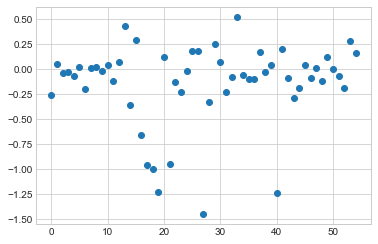

In [103]:
plt.plot(resids, 'o')
plt.show()

In [38]:
n = 10 # number of years
m = 8 # number of features
k = 55 # number of PUMAs
years_ints = np.array(years).astype('int')
test_years = years_ints[0:n]
points_per_year = 12
X_interpolated = si.interpolate.interp1d(test_years,X,axis=1,kind='linear')
Y_interpolated = si.interpolate.interp1d(test_years,Y,axis=1,kind='linear')
ts = np.linspace(test_years[0], test_years[-1],n*points_per_year)

In [39]:
Y_interpolated(ts).shape

(55, 120)

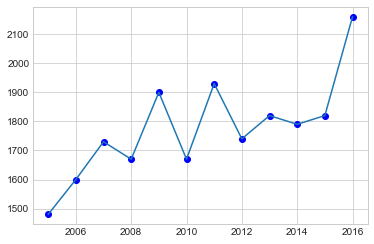

In [195]:
y = median_rents[years].iloc[15].transpose().values
xs = np.array(map(int, years))
ax = plt.plot(yearsnum,y, 'bo')
f = si.interpolate.interp1d(yearsnum,y,kind='linear')
xnew = np.arange(yearsnum[0], yearsnum[-1] + 0.1, 0.1)
ynew = f(xnew)
plt.plot(xnew, ynew)
plt.show()

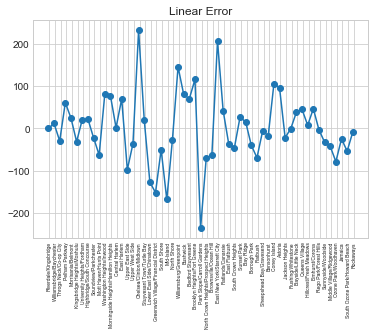

In [61]:
sns.set_style('whitegrid')
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
ax.set_title('Rents Actual vs Predicted')
ax.set_xticks(ind + width / 2)
errs = predictions - Y_test
p1 = ax.plot(errs, 'o-')
ax.set_title('Linear Error')
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.yaxis.set_label("Monthly Rent (Dollars)")
plt.show()

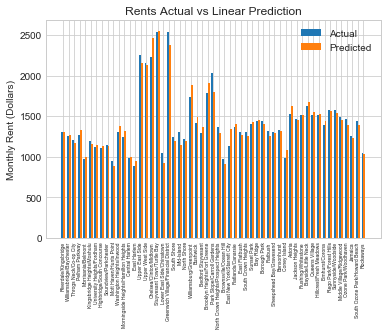

In [62]:
sns.set_style("whitegrid")
N = 55
fig, ax = plt.subplots()
width = 0.35
ind = np.arange(N)
p1 = ax.bar(ind, Y_test, width, bottom=0)
p2 = ax.bar(ind + width, predictions, width, bottom=0)
ax.set_title('Rents Actual vs Linear Prediction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(median_rents['Sub-Borough Area'], rotation='vertical', fontsize = 5)
ax.legend((p1[0], p2[0]), ('Actual', 'Predicted'))
plt.ylabel("Monthly Rent (Dollars)")
plt.show()

In [54]:
colors = sns.cubehelix_palette(8)
colors

[[0.9312692223325372, 0.8201921796082118, 0.7971480974663592],
 [0.8822898168737189, 0.695820866705742, 0.7065457119485431],
 [0.8135380254700676, 0.5705055182357822, 0.639280859468155],
 [0.7195800708349119, 0.45537982893127477, 0.5861062995810926],
 [0.6046906802634469, 0.35739308184976665, 0.5337407853692406],
 [0.46496993672552045, 0.26868986121314253, 0.4636527763640647],
 [0.3210194743259347, 0.19303051265196464, 0.3707881677724792],
 [0.1750865648952205, 0.11840023306916837, 0.24215989137836502]]

In [21]:
row = neighbor_means.loc[3702]
plt.plot(years, row[years], color = colors[5])
plt.xlabel('Year')
plt.ylabel('Rent (Dollars)')
plt.title('Mean Rent of Adjacent Neighborhoods')
plt.show()

NameError: name 'neighbor_means' is not defined

$$x_i = \frac{1}{N_i}\sum_{j \in n(i)} x_j $$

In [22]:
$$\frac{N}{W}\frac{}{}

SyntaxError: invalid syntax (<ipython-input-22-a3695cb7cbd7>, line 1)